# Making sense of text through NLP and machine learning

80% of the data that resides in companies have been estimated to be unstructured i.e. data that is not organized in a way that allows easy analysis. We are surrounded by this kind of data and comes often in textual form such as emails, memo's, social media posts, articles and endless documents. Immediately regarding this data as useless for data analysis techniques such as machine learning models would be naive. You might be surprised how much we already can do.

This article has a different setup than you might be used to from IThappens. Instead of only discussing concepts and how they impact business, this article will also offer code in Python to demonstrate how to bring it in practice. This article will not go in depth into the coding language used or technologies used, but I will provide you with usefull links if you want to learn more and invite you to play around with the code.

The dataset used in this article is rather trivial, but depending on your lifestyle, the data might interest some of you to a great extend. This dataset contains 150,000 wine reviews gathered by a Kaggle users. Every entry contains the name, price, country of origin, textual review and points of the wine. The goal of the excercise in this article is trying to classify if a wine is a top wine (at least 9 out of 10 points) based on the textual review.

Important is to note that there is no "one" true best model, or as they like to say in machine learning: there is no free lunch. Therefore, we have to work through trial and error untill we find something that give satisfactory results. 

In [3]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import jsonlines
import keras
import scipy
import pandas as pd
from keras import Sequential
from keras import layers
from sklearn.metrics import recall_score, accuracy_score

## Load and pre-process data

First, we are going to load the data, look at some examples and prepare the data in order to train some models on it. Collecting, exploring and pre-processing your data could take up to 80% of a whole data science project. Luckily, the data is available in a csv file and little pre-processing is necessary.

The data will be loaded in a pandas data frame, which allows easy exploration and visualisation of our data. 

In [4]:
df = pd.read_csv("winemag-data_first150k.csv", encoding="utf-8")

The best way to explore our data is to simply look at. Below the first 5 entries and the first 5 whole reviews are presented.

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
#example of a description
for text in (df.description[0:5]):
    print(text)
    print('\n')

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.


Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.


Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.


This spent 20 months in 30% new French

We can notice that not every description has the same length. This could be problematic for training a model on the descriptions, since a longer description can contain much more important terms that can indicate the quality of the wine compared to smaller descriptions. Plotting the length of the descriptions reveals a substantial amount of outliers. Therefore, the descriptions will be restricted to 1 or 2 sentences, which corresponds roughly to sentences with between 15 and 40 words.

Text(0, 0.5, 'Number of words')

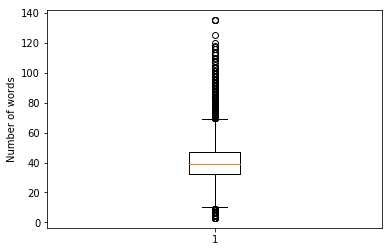

In [6]:
text_length = [len(text.split()) for text in df.description]
plt.boxplot(text_length)
plt.ylabel("Number of words")

In [7]:
#filtering out all the descriptions that do not meet our criteria
df['description'] = df['description'].astype('str')

filtered = df[df.description.str.split().apply(len) > 15]
data = filtered[filtered.description.str.split().apply(len) < 45]


Text(0, 0.5, 'Number of words')

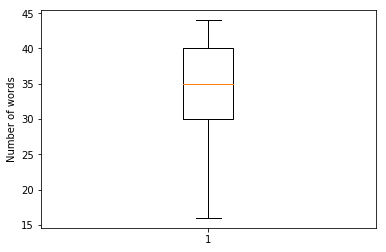

In [9]:
text_length = [len(text.split()) for text in data.description]
plt.boxplot(text_length)
plt.ylabel("Number of words")

To check how many of our original data we are left with, we simply compare the number of old entries with our filtered data. 66% of our data has been preserves, which still mean that we are left with a hefty data set of 100,000 wines.

In [11]:
#around 2/3 of the data is being kept
len(data.description)/len(df.description)*100

66.5162658185914

Additionally, we have to label our data in a fitting manner. Since we only deal with two classes, top wines and other wines, the task at hand is binary classification. Therefore, we can simple label the top wines with a 1 and the other wines with 0.

In [18]:
data["categorical"] = [1 if score > 90 else 0 for score in data.points]
data["categorical"].value_counts()

C:\Users\Kees\Anaconda\envs\Thesis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    87065
1    13328
Name: categorical, dtype: int64

This is not the end of this section. Before we can train models on our data, we would like to define what would constitute to a good performance. It might be a good idea to look at the distribution of wine points in our data set. 

The plot below shows us clearly that most of our wines do not belong to the top wines (at least 9 out of 10 points). This means that our data is *unbalanced*, which might result in problems for training a model on the data.

Text(0.5, 1.0, 'wine points distribution')

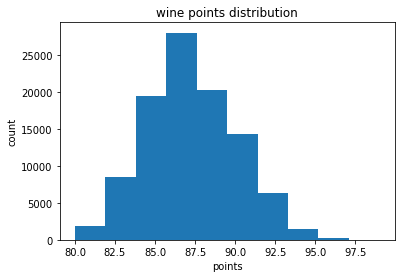

In [15]:
plt.hist(data.points)
plt.ylabel("count")
plt.xlabel("points")
plt.title("wine points distribution")

Our excercise has the goal to correctly classify all the top wines. We could easily label all of our wines as top wines and call it a day. While some of us do not really care about the quantity of wine, but if we want to try all the top wines, we do not want to try all the other wines to. Therefore, we should evaluate our models on two metrics: *accuracy* and *recall*.

Accuracy is the percentage of how many wines we classified correctly from *all* the wines. 
Recall is the percentage of many wines we classfied correctly from the *top* wines. 

We would like to get our recall as high as possible and our accuracy at least higher than the case where we classify everything as a inferior wine. 

In [21]:
predictions = [0 for i in data.points]
print("Accuracy: " + str(accuracy_score(predictions, data.categorical)))
print("Recall: " + str(recall_score(predictions, data.categorical)))

Train accuracy: 0.8672417399619495
Train recall: 0.0


C:\Users\Kees\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Further, we should not evaluate on the data on which we trained. When you studhy for an exam, you study (or train) on different excercises than the excercises in the exam. If you would have been studying by using the excercises in the exam, the exam would not fairly evaluate your knowledge on the subject. Therefore, we split the data in a large training set and a smaller set for evaluating our models. The code below dives the data in 75% and 25% for the train and test set respectively.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.description, data.categorical, test_size = 0.25, random_state = 42)

# Embeddings

This section might be the most complicated of this excersice. In order to let machine learning models work with the descriptions, the text needs to be converted to numerical representations such a vectors. For this problem, sentence embeddings are used in order to capture the semantics of the whole sentence(s).

Simply put, embeddings give sentences that are similair in semantics similair vectors. As a result, similair sentences are mapped closed together in the feature space. This description clearly does not justify the miracelous and complex workings of sentence embedding models and the larger field of language understanding. This field has seen a tremendous amount of advancement in recent years and record after record is being broken every few months. If you would like to read more on this topic, I advice to start with ...

The convert the text to vectors, a pre-trained Skip-Thought model has been used. The model has been trained on a large data set on which it learned to predict the previous and next sentence given the input sentence. The idea is that by learning surrounding sentences, the semantics of the input sentence can be learned. This model can be used to pre-process sentences for different NLP tasks. 

In [ ]:
from skip_thoughts import configuration
from skip_thoughts import encoder_manager
from sklearn.linear_model import LinearRegression


In [14]:
#prepare the data for the encoder
skt_data = [line.strip() for line in data.description]
assert len(skt_data) == len(data.description)

In [15]:
bi_skt_encoder = encoder_manager.EncoderManager()
bi_skt_encoder.load_model(configuration.model_config(bidirectional_encoder=True),
                   vocabulary_file= r"C:\Users\Kees\Python\Thesis_CSAI\skipthought\skip_thoughts_bi_2017_02_16\vocab.txt",
                   embedding_matrix_file=r"C:\Users\Kees\Python\Thesis_CSAI\skipthought\skip_thoughts_bi_2017_02_16\embeddings.npy",
                   checkpoint_path=r"C:\Users\Kees\Python\Thesis_CSAI\skipthought\skip_thoughts_bi_2017_02_16\model.ckpt-500008")

INFO:tensorflow:Reading vocabulary from C:\Users\Kees\Python\Thesis_CSAI\skipthought\skip_thoughts_bi_2017_02_16\vocab.txt
INFO:tensorflow:Loaded vocabulary with 930914 words.
INFO:tensorflow:Loading embedding matrix from C:\Users\Kees\Python\Thesis_CSAI\skipthought\skip_thoughts_bi_2017_02_16\embeddings.npy
INFO:tensorflow:Loaded embedding matrix with shape (930914, 620)
INFO:tensorflow:Building model.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Loading model from checkpoint: C:\Users\Kees\P

Converting the sentences to embeddings takes some time and we would not like to run the Skip-Thought model everytime we restart our computer. Therefore, we save them in a pickle file

In [16]:
bi_skt_embedding = bi_skt_encoder.encode(skt_data)

bi_skt_embedding_file = open('bi_skt_embedding_file', 'wb')

pickle.dump(bi_skt_embedding, bi_skt_embedding_file)
bi_skt_embedding_file.close()

The three lines of code below allow us to load the embeddings from the pickle file.

In [ ]:
file = open('bi_skt_embedding_file', "rb")
embeddings = pickle.load(file)
file.close()

To check if all the embeddings are loaded, we can check the shape of the embeddings. Around 100,000 vectors with size 2400.

In [17]:
bi_skt_embedding.shape

(100393, 2400)

2400 might be too much for our task and will make our machine learning models a bit too complex. Sklearn offers us a neat trick: principle component analysis (PCA). Simply put, PCA allows us to reduce the dimensions (features) while trying to preserve the information stored in the initial dimensions. The exact working of the algorithm behind PCA can be a bit daunting, so I included a gif that might give you some intuition on how it works.

![PCAUrl](https://miro.medium.com/max/770/1*UpFltkN-kT9aGqfLhOR9xg.gif "PCA")

Source: https://medium.com/@raghavan99o/principal-component-analysis-pca-explained-and-implemented-eeab7cb73b72

We need to fit the PCA on our data in order to let the PCA-model learn its distribution. Important is to note that we fit the PCA on our training data and not on our testing data. We do not want the test data to influence how the train data is pre-processed. It is always important to keep in mind what pre-processing techniques we can apply on our train and test data!

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(embeddings, data.categorical, random_state  = 42)
#Delete this??

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# KNN

The first model that we will train on our data is K-nearest neighbour. This is a fairly simple model that can work remarkably well on certain data sets. The model remembers the positions in the feature space of all the examples in the train set. When it is asked to classify a wine from the test data set, the model looks at the classes of *k* nearest wines in the feature space and through majority vote classifies the wine.

This model has one major weakpoint: it cannot handle data with a lot of dimensions well. This weakness is also called the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Therefore, we will apply PCA again, specifically for KNN. 20 dimensions seem to be reasonable.

In [22]:
knn_pca = PCA(n_components = 20)

X_train_knn = knn_pca.fit_transform(X_train)
X_test_knn = knn_pca.transform(X_test)

We import the KNN classifier from Sklearn and fit our training examples on it in three lines of code. Yes, this easy it can be.

In [1]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_knn, y_train_label)

After fitting the model, we can ask it to classify wines. We make a difference between the performance on the wines in the training set (on which the model is trained) and the wines in the test set. Obviously, the model performs better on data on which it has been trained than on data it has never seen. Imagine, if all the assignments on an exam would be the same as the assignments you used to study with. It would make for a rather easy exam.

KNN performs rather well on the training set. The model is able to identify more than 70% of the top wines. On the test the accuracy is not much higher than our baseline of 0.867. The recall is also much lower, around 50%.


In [25]:
print("Train accuracy: " + str(knn.score(X_train_knn, y_train_label)))
print("Train recall: " + str(recall_score(knn.predict(X_train_knn), y_train_label)))


Train accuracy: 0.9061545408664701
Train recall: 0.7414578587699316


In [26]:
print("Test accuracy: " + str(knn.score(X_test_knn, y_test_label)))
print("Test recall: " + str(recall_score(knn.predict(X_test_knn), y_test_label)))


Test accuracy: 0.8681222359456552
Test recall: 0.49576719576719575


The phenomenon in which a model score much higher on the training set than on the test set is called *overfitting*. When a model overfits, the model is only good in classifying or predicting on the data it has seen and not on the data it has never seen. 

A good analogy to understand overfitting are the [anti-tank dogs](https://en.wikipedia.org/wiki/Anti-tank_dog) trained by the Sovjets. Dogs were meant to be trained to leave explosive packages under German tanks, which would be detonated. The dogs were trained on Sovjet diesel tanks and not on German gasoline tanks. Unsuprisingly, when deployed, the dogs ran towards the familiar Sovjet tanks instead of the German tanks. This meant that the dogs had been trained too well on the Sovjet tanks.

## Logistic Regression

The second model we will take a look at is logistic regression, a cousin of linear regression. The main difference between the models is that linear regression can be used to predict a continious value, while logistic regression can be used to classify e.g. either 0 or 1. The curve of a logistic regression model fitted on only one feature looks like this:

![LGurl](https://miro.medium.com/max/770/1*zfH9946AssCx4vzjaizWeg.png "LG")

Source: https://miro.medium.com/max/770/1*zfH9946AssCx4vzjaizWeg.png

Instead of one variable, we have 1000 variables. Just try to imagine how such a line would look like in a 1000 dimensional plane. Luckily, Python and the Sklearn LogisticRegression model will take care of this.


In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_reduced, y_train_label)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The performance on the training set is lower than the performance of KNN. However, the difference betweent the performance on the training set and test set is much lower. The logistic regression does not overfit and outperforms the KNN!

In [28]:
print("Train accuracy: " + str(clf.score(X_train_reduced, y_train_label)))
print("Train recall: " + str(recall_score(clf.predict(X_train_reduced), y_train_label)))

Train accuracy: 0.8932982707785481
Train recall: 0.7241147467503362


In [29]:
print("Test accuracy: " + str(clf.score(X_test_reduced, y_test_label)))
print("Test recall: " + str(recall_score(clf.predict(X_test_reduced), y_test_label)))

Test accuracy: 0.8917885174708156
Test recall: 0.6918990703851262


## Feed-forward network

So we have arrived at the (in)famous branch of machine learning: neural networks. They have achieved unbelievable results on tasks that include object classification, natural language generating and machine translation. I would have no idea where to start to explain how these networks work; calling them complex would be an understatement. They consist of conventional linear or logistic models on steroids stacked on top of eachother. They are notorious for overfitting and ideally require much more data than we have in our example. If you are interested in learning about how such models work, I advise to start to watch the great videos of [Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk) and then progress with http://www.deeplearningbook.org/. 

Below, a relatively simple feed-forward network has been constructed by using the keras package. This package is ideal when starting to use neural networks in Python. Due to how neural networks, we have to change the encoding of the labels from 0 (mediocere wine) to [1, 0] and from 1 (top wine) to [0, 1].

In [30]:
from keras.utils import np_utils
# convert integers to dummy variables (i.e. one hot encoded)
train_dummy_y = np_utils.to_categorical(y_train_label)
test_dummy_y = np_utils.to_categorical(y_test_label)

First we initialize a model. Next, we add layers to the model. The model below has one input layer with 64 nodes, one hidden layer with 32 nodes and one output layer with 2 nodes, corresponding to the number of wine classes we have. The compile method specifies how the model will be trained; for the scope of this article, I will not get in too much detail on this.

In [36]:
model = Sequential()

model.add(layers.Dense(64, activation = "relu", input_shape = (1000, )))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                64064     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 66,210
Trainable params: 66,210
Non-trainable params: 0
_________________________________________________________________


We can utilize some tricks to help our model to train and to reduce the training time. First, we specifiy the weights the model should attach to the errors of the classes. Since we have far less top wines in our data set, we weigh them more than the other wines. The weights are proportional to the proportion of classes in the training data. This helps to increase the recall on our unbalanced data set.

Second, we use early stopping. The model will be trained in a given number of rounds i.e. epochs. With early stopping, we ask the model to check the accuracy of the model on the test data set. If the accuracy does not increase substantially in 5 rounds straight, the model stops training. This method can reduce overfitting and shortens the training time.

In [ ]:
class_weight = {1:1/(np.sum(y_train_label)/ len(y_train_label)), 0:1}

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5)

Now, we finally train our model. Additionaly to the training data, we specify the test data as validation data, set the amount of epochs to 50, point to the class weights and specify earlystopping. Below, you can see the performance of the model increasing over the epochs. Due to early stopping, our model is done after 24 epochs instead of 50 epochs, which cuts the training time in half.

After the model is done training, we plot the accuracy on the training and test set for each epoch. Further, we print the recall scores.

Train on 75294 samples, validate on 25099 samples
Epoch 1/50
75294/75294 [==============================] - 9s 122us/step - loss: 0.8636 - acc: 0.7452 - val_loss: 0.4774 - val_acc: 0.7574
Epoch 2/50
75294/75294 [==============================] - 6s 74us/step - loss: 0.7394 - acc: 0.7848 - val_loss: 0.4280 - val_acc: 0.7905
Epoch 3/50
75294/75294 [==============================] - 6s 81us/step - loss: 0.6613 - acc: 0.8115 - val_loss: 0.4815 - val_acc: 0.7695
Epoch 4/50
75294/75294 [==============================] - 5s 70us/step - loss: 0.5767 - acc: 0.8424 - val_loss: 0.3508 - val_acc: 0.8416
Epoch 5/50
75294/75294 [==============================] - 5s 71us/step - loss: 0.5032 - acc: 0.8661 - val_loss: 0.3213 - val_acc: 0.8616
Epoch 6/50
75294/75294 [==============================] - 5s 71us/step - loss: 0.4384 - acc: 0.8859 - val_loss: 0.3444 - val_acc: 0.8562
Epoch 7/50
75294/75294 [==============================] - 6s 80us/step - loss: 0.3934 - acc: 0.9003 - val_loss: 0.3232 - val_ac

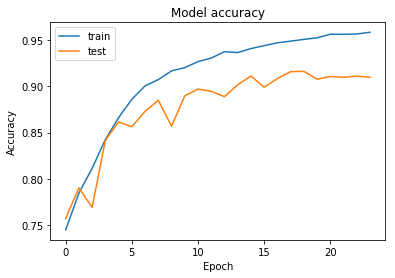

Recall train:  0.9997010165437512
Recall test:  0.7802064359441409


In [38]:
history = model.fit(X_train_reduced, train_dummy_y, validation_data=(X_test_reduced, test_dummy_y), epochs = 50, class_weight=class_weight, callbacks = [es])

plt.plot(history.history['acc'], label = "train")
plt.plot(history.history['val_acc'], label = "test")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print("Recall train: ", recall_score(np.argmax(train_dummy_y, axis = 1),  np.argmax(model.predict(X_train_reduced), axis = 1)))
print("Recall test: ", recall_score(np.argmax(test_dummy_y, axis = 1),  np.argmax(model.predict(X_test_reduced), axis = 1)))

As we see clearly in the plot, our model overfitted. The accuracy on the training set is well above 95%, while the accuracy on the test set does not surpass much above 90%. We see the same on the recall. In the training set, almost 100% of the top wines are classified correctly, while 78% of the top wines are classified correctly in the test set. Nevertheless, this model is the top performer so far.

# Gradient Boosting

We have arrived at our last model: gradient boosting. To be honest, I never used this model before writing this article. I read online that this model is often being used in online data science challanges and often ends in the top, so I thought I can give it a try. I had the idea that in the end nothing can really top the accuracy and recall of a neural network; I could not have been more wrong. 

An extreme oversimplification of how this model works:
* Fit a model to the data: F(x) = y
* Fit a model to the residuals: h(x) = y - F_1(x)
* Create a new model
* Repeat

In the end, you have an esemble of models that individually would not perform competitive on the data, but together can achieve impressive results.

The gradient boosting implementation of [XGBoost](https://xgboost.readthedocs.io/en/latest/) has been used. The classifier has all the default hyperparameters, except max_depth is set from 3 to 8.

In [45]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth = 8)
model.fit(X_train_reduced, y_train_label)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [46]:
predictions = model.predict(X_train_reduced)
print("Train accuracy: " + str(accuracy_score(predictions, y_train_label)))
print("Train recall: " + str(recall_score(predictions, y_train_label)))
predictions = model.predict(X_test_reduced)
print("Test accuracy: " + str(accuracy_score(predictions, y_test_label)))
print("Test recall: " + str(recall_score(predictions, y_test_label)))

C:\Users\Kees\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy: 0.9840624750976174
Train recall: 0.998307761732852
Test accuracy: 0.9258536196661221
Test recall: 0.9197422378441711


C:\Users\Kees\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


When I first saw these results I was baffled. The recall on the test set smashes the results from the neural network. I never expected to be able to identify over 90% of all the top wines in the data set.

## Conclusion

In this article I showed how you can utilize a wide range of methods and models to make sense of text. I hope you take away from this article:
* How to go about converting raw text to data on which we can train models
* Which metrics you can use to evaluate models
* The notion that there is no silver bullet in machine learning
* And of course, the ridiculous performance of gradient boosting

This article demonstated how one could go about a rather simple classification problem using embeddings and four different machine learning models. However, there are still a wide range of options to try out on this data set or a similair one:
* Try to use a more recent and state of the art sentence embedding model such as BERT or XLNet.
* Most models have been used with their default hyperparameters. See if you can increase the performance by applying cross validation.
* Instead of classifying top wines, you can also try to predict the actual score of the wine, which would make this a regressions problem instead of a classification problem.

You can access the notebook of this code online with the following link: 